In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import argparse
import os
import shutil
import time
import random
import copy


import torch
from sklearn.metrics import precision_score,recall_score
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose

import torchmetrics

#from torchinfo import summary

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
import torch.nn.parallel
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, random_split
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np

In [3]:
import argparse
import os
import shutil
import time
import random
import numpy as np

import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

In [4]:
import torch
import torch.nn as nn

torch.autograd.set_detect_anomaly(True)

In [5]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [140]:
class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(CustomBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out += self.shortcut(identity)
        out = nn.ReLU(inplace=True)(out)
        return out

In [172]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.layers = nn.Sequential(
            resnet18.conv1,
            resnet18.bn1,
            resnet18.relu,
            resnet18.maxpool,
            resnet18.layer1[0],
            #resnet18.layer1[1],
            #CustomBlock(64,64),
            resnet18.layer2[0],
            #resnet18.layer2[1],
            #CustomBlock(128, 128, stride=2),  # Added custom block to layer2
            resnet18.layer3[0],
            #resnet18.layer3[1],
            resnet18.layer4[0],
            
        )

    def forward(self, x):
        return self.layers(x) 

In [173]:
# Instantiate the model
model =  FeatureExtractor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4898112


In [42]:
# Instantiate the model
model = FeatureExtractor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.weight - 1728
layers.1.weight - 64
layers.1.bias - 64
layers.4.weight - 36864
layers.5.weight - 64
layers.5.bias - 64
layers.6.weight - 73728
layers.7.weight - 128
layers.7.bias - 128
layers.8.weight - 294912
layers.9.weight - 256
layers.9.bias - 256
layers.10.weight - 1474560


In [174]:
class Predictor(nn.Module):
    def __init__(self, num_classes=10):
        super(Predictor, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

In [175]:
# Instantiate the model
model =  Predictor()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4725770


In [45]:
# Instantiate the model
model = Predictor()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 5120
layers.3.bias - 10


In [179]:
class Attacker(nn.Module):
    def __init__(self, num_classes=1):
        super(Attacker, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.layers = nn.Sequential(
            resnet18.layer4[1],
            resnet18.avgpool,
            nn.Flatten(),
            nn.Linear(resnet18.fc.in_features, num_classes), 
        )

    def forward(self, x):
        x = self.layers(x)
        x = torch.sigmoid(x)
        return x


In [180]:
# Instantiate the model
model =  Attacker()

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {num_params}")

Number of parameters: 4721153


In [48]:
# Instantiate the model
model = Attacker()

# Count the number of parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.numel()}")

layers.0.conv1.weight - 2359296
layers.0.bn1.weight - 512
layers.0.bn1.bias - 512
layers.0.conv2.weight - 2359296
layers.0.bn2.weight - 512
layers.0.bn2.bias - 512
layers.3.weight - 512
layers.3.bias - 1


In [49]:
class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].shape[0] == tensor.shape[0] for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        X = self.tensors[0][index]
        if self.transform is not None:
            X = self.transform(X)
        return X, tuple(self.tensors[i][index] for i in range(1, len(self.tensors)))
    
    def __len__(self):
        return self.tensors[0].shape[0]

In [50]:
tfms = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 100


#50k clf_trainds
clf_trainds = CIFAR10(root='PyTorch-StudioGAN/data/', transform=tfms)

#clf_train_idx = 25k
#clf_test_idx = 25k
clf_train_idx, clf_test_idx = train_test_split(
    np.arange(len(clf_trainds.targets)), test_size=0.5, shuffle=True, stratify=clf_trainds.targets
)
train_sampler = sampler.SubsetRandomSampler(clf_train_idx)
test_sampler = sampler.SubsetRandomSampler(clf_test_idx)

#creating clf_train and clf_test dataloader
clf_train_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=train_sampler)
clf_test_dl = DataLoader(clf_trainds, batch_size=batch_size, sampler=test_sampler)

#creating attacker dataset
y_true_atk = [t for t in clf_trainds.targets]
#25k 0 and 25k 1
y_atk = np.zeros(len(clf_trainds), dtype=int)
y_atk[clf_train_idx.tolist()] = 1

atk_trainds = CustomTensorDataset(
    tensors=(clf_trainds.data,torch.tensor(y_true_atk), torch.tensor(y_atk)),
    transform=tfms
)
atk_train_idx, atk_test_idx = train_test_split(
    np.arange(len(atk_trainds.tensors[2].tolist())), test_size=0.2, shuffle=True, stratify=atk_trainds.tensors[2].tolist()
)
atk_train_sampler = sampler.SubsetRandomSampler(atk_train_idx)
atk_test_sampler = sampler.SubsetRandomSampler(atk_test_idx)

atk_train_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_train_sampler)
atk_test_dl = DataLoader(atk_trainds, batch_size=batch_size, sampler=atk_test_sampler)



In [51]:

def adjust_learning_rate(epoch, init_lr=0.001):
    schedule = [12]
    cur_lr = init_lr
    for schedule_epoch in schedule:
        if epoch >= schedule_epoch:
            cur_lr *= 0.1
    return cur_lr

In [52]:
#pretraining FE+CF
criterion = nn.CrossEntropyLoss()
train_loss = []
test_loss = []
test_acc = []

def train_FE_CF2(FE, CF, data_train_loader, current_lr, vis=None):
    FE.train()
    CF.train()
    FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    for i, (images, labels) in enumerate(data_train_loader):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        features = FE(images)
        # feed only private images to the classifier
        output_CF = CF(features)
        loss_CF = criterion(output_CF, labels)
        

        FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        FE_optimizer.step()
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\t'.format(
                i, i * len(images), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item()))

    return FE, CF

In [53]:
def test_FE_CF2(FE, CF, data_test_loader):
    FE.eval()
    CF.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #size= len(data_test_loader)//2

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_test_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            features = FE(images)
            #classfier_features= features[privlabe==1]
            output = CF(features)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            avg_acc += pred.eq(labels.view_as(pred)).sum()
            counter += 1

    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)

In [54]:
test_atk_loss=[]  # list to store loss values
def eval_clf(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            test_atk_loss.append(loss)  # add loss to list
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [159]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file = os.path.join(save_dir, 'FE.pth')
cf_model_file = os.path.join(save_dir, 'CF.pth')
inf_model_file=os.path.join(save_dir,'INF.pth')

In [160]:
total_epoch=300
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf_criterion = nn.CrossEntropyLoss().to(device)
def get_FE_CF():
    FE = FeatureExtractor()
    CF = Predictor()
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            FE = torch.nn.DataParallel(FE)
            CF = torch.nn.DataParallel(CF)
        FE = FE.cuda()
        CF = CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, CF = train_FE_CF2(FE, CF, clf_train_dl, current_lr, vis=None)
            #test_FE_CF2(FE, CF, clf_test_dl)
            eval_clf(FE,CF,clf_test_dl,clf_criterion,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(CF.module, "Models/mix/pre_train/CF.pth")
    else:
        torch.save(FE, fe_model_file)
        torch.save(CF, cf_model_file)

    return FE, CF

In [176]:
#overfitting on data
FE, CF = get_FE_CF()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 2.705234	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 1.306719	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.980487	
Classifier Loss: 1.164642389535904 | Classifier Accuracy: 0.593999981880188
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.874087	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.841923	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.828786	
Classifier Loss: 1.3524668264389037 | Classifier Accuracy: 0.5938400030136108
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.570563	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.656942	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.896115	
Classifier Loss: 0.7984222565889358 | Classifier Accuracy: 0.7308400273323059
epoch 3
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.364504	
Epoch: 100 [10000/50000 (40%)]	Loss Classifier: 0.585820	
Epoch: 200 [20000/50000 (80%)]	Loss Classifier: 0.577726	
Classifier Loss: 0.7495935932397843 | Classifier Accuracy: 0.7556399

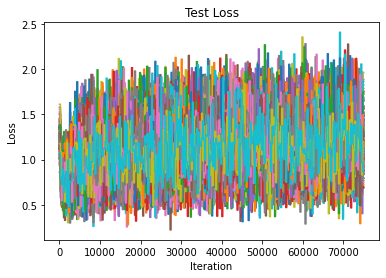

In [22]:
    # plot loss values to see overfittig
import matplotlib.pyplot as plt
plt.plot(test_atk_loss)
plt.title('Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [181]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad_(False) 
    model.eval()

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad_(True)
    model.train()

In [182]:
def get_precision_recall(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, predicted, average='macro',zero_division=0)
    recall = recall_score(labels, predicted, average='macro')
    return precision, recall

In [183]:
#train pretrained FE+attacker
device = 'cuda' if torch.cuda.is_available() else 'cpu'
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
#train_losses = []
def train_FE_INF(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(atk_train_dl):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)
        features = FE(X)
        # feed them to the inf model
        pred_private_labels = INF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        ######
        #train_losses.append(loss_INF.item())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.detach().item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return FE, INF

In [184]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_FE_INF(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
#           private_labels,n=private_labels_gaining(labels)
            features = FE(X)
            output = INF_model(features)
            #output=torch.round(output)
            #y2=y2.float()
            y2= y2.unsqueeze(1)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)

In [185]:
total_epoch=100
lr=0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_FE_INF():
    FE = torch.load(fe_model_file)
    INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            FE, INF = train_FE_INF(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_FE_INF(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "Models/mix/pre_train/FE.pth")
        torch.save(INF.module, "Models/mix/pre_train/CF.pth")
    else:
        #torch.save(FE, fe_model_file)
        torch.save(INF, inf_model_file)
    return FE, INF

In [186]:
FE, INF = get_FE_INF()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.749126	 Precision attacker: 0.002900	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.675605	 Precision attacker: 0.002500	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.658101	 Precision attacker: 0.002400	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.624938	 Precision attacker: 0.001900	 recall attacler: 0.005000	
Test Avg. Loss: 0.667841, Accuracy: 60.810000
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.674487	 Precision attacker: 0.002850	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.644141	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.713328	 Precision attacker: 0.002950	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.645544	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Test Avg. Loss: 0.664701, Accuracy: 62.390000
ep

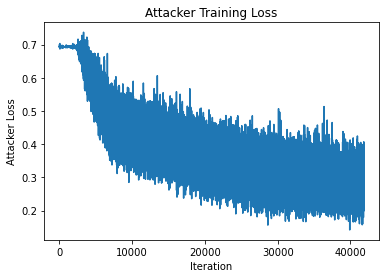

In [242]:
#plotting attacker loss during training 
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Iteration')
plt.ylabel('Attacker Loss')
plt.title('Attacker Training Loss')
plt.show()

In [187]:
criterion = nn.CrossEntropyLoss().cuda()
loss_fn = nn.BCEWithLogitsLoss().cuda()

def train(FE_model,INF_model, CF_model, trainloader, current_lr,current_lr_atk,tradoff=0.25 ):
    FE_model.train()
    INF_model.train()
    CF_model.train()
    #tradoff=0
    
    FE_optimizer = optim.Adam(FE_model.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF_model.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF_model.parameters(), lr=current_lr_atk, weight_decay=1e-4)
    
    for i, (images, (labels, privlabels)) in enumerate(trainloader):
        if torch.cuda.is_available():
            images, labels, privlabels = images.cuda(), labels.cuda(), privlabels.cuda()

        # get features from the feature extractor
        features = FE_model(images)
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())

        # feed only private images==1 to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        
        # compute loss and backprop
        loss = -tradoff * loss_INF + (1. - tradoff) * loss_CF
        
        FE_optimizer.zero_grad()
        loss.backward()
        FE_optimizer.step()

        
         # get features from the feature extractor
        features = FE_model(images).detach()
        INF_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        
        # feed them to the inf model
        pred_private_labels = INF_model(features)
        loss_INF = loss_fn(pred_private_labels, privlabels.reshape(-1,1).float())
        loss_INF.backward()
        INF_optimizer.step()

       
        # feed only private images to the classifier
        classifier_features = features[privlabels == 1]
        output_CF = CF_model(classifier_features)
        loss_CF = criterion(output_CF, labels[privlabels == 1])
        loss_CF.backward()
        CF_optimizer.step()

        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss Classifier: {:.6f}\tLoss Attacker: {:.6f}'.format(
                i, i * len(images), len(trainloader.dataset),
                100. * i / len(trainloader), loss_CF.item(), loss_INF.item()))

    return FE_model, INF_model, CF_model       

In [188]:
# create a directory to save models
save_dir = os.path.join(os.getcwd(), 'resnet-0.25')
os.makedirs(save_dir, exist_ok=True)

# define the file name for each model
fe_model_file_defense = os.path.join(save_dir, 'FE_defense.pth')
cf_model_file_defense = os.path.join(save_dir, 'CF_defense.pth')
inf_model_file_defense = os.path.join(save_dir, 'INF_defense.pth')

In [189]:
total_epoch=300
lr=0.0001
lr_atk=3e-3
#lr=0.1
tradoff=0.25
def get_FE_defense():
    #using FE and CF after pretraining them
    FE = torch.load(fe_model_file)
    #FE=AlexNet_FE()
    #CF=AlexNet_predictor()
    CF = torch.load(cf_model_file)
    INF=torch.load(inf_model_file)
    #INF = Attacker()
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF = CF.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            current_lr_atk = adjust_learning_rate(epoch,lr_atk)
            FE, INF, CF =train(FE,INF, CF, atk_train_dl, current_lr,current_lr_atk, tradoff)
            #test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass
    if torch.cuda.device_count() > 1:
        torch.save(FE.module, "FE_defense.pth")
        torch.save(CF.module, "CF_defense.pth")
        torch.save(INF.module, "INF_defense.pth")
    else:
        torch.save(FE,fe_model_file_defense)
        torch.save(INF,inf_model_file_defense)
        torch.save(CF, cf_model_file_defense)
    return FE

In [190]:
FE=get_FE_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.000421	Loss Attacker: 0.646976
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000288	Loss Attacker: 0.699959
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000755	Loss Attacker: 0.679404
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.000810	Loss Attacker: 0.699085
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.000714	Loss Attacker: 0.706897
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000256	Loss Attacker: 0.664464
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000859	Loss Attacker: 0.702988
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.000427	Loss Attacker: 0.691943
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss Classifier: 0.000612	Loss Attacker: 0.696041
Epoch: 100 [10000/50000 (25%)]	Loss Classifier: 0.000279	Loss Attacker: 0.666837
Epoch: 200 [20000/50000 (50%)]	Loss Classifier: 0.000858	Loss Attacker: 0.696920
Epoch: 300 [30000/50000 (75%)]	Loss Classifier: 0.000292	Loss Attacker: 0.681092
epoch 3
Epoch: 0 [0/50000

In [191]:
#train attacker after applying our defense
atk_criterion = nn.BCEWithLogitsLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_attacker_defense(FE, INF, data_train_loader, current_lr,device, vis=None):
    INF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    INF_optimizer = optim.Adam(INF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_INF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, (y1, y2)) in enumerate(data_train_loader):
        #if torch.cuda.is_available():
        X, y1,y2= X.to(device), y1.to(device),y2.to(device)

        features = FE(X)
        # feed them to the inf model
        pred_private_labels = INF(features)
        #y2=y2.float()
        y2 = y2.unsqueeze(1)
        loss_INF =atk_criterion(pred_private_labels,y2.float())
        precision, recall = get_precision_recall(pred_private_labels,y2)
        #FE_optimizer.zero_grad()
        INF_optimizer.zero_grad()
        loss_INF.backward()
        INF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss attacker: {:.6f}\t Precision attacker: {:.6f}\t recall attacler: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_INF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  INF

In [192]:
INF_test_loss=[]
INF_test_acc=[]
loss_fn = nn.BCEWithLogitsLoss().to(device)
def test_attacker_defense(FE, INF_model, data_test_loader,device):
    FE.eval()
    INF_model.eval()

    avg_loss = 0
    avg_acc = 0
    counter = 0
    #total_samples = 0

    with torch.no_grad():
        for i, (X,(y1,y2)) in enumerate(data_test_loader):
            #if torch.cuda.is_available():
            X,y1,y2=X.to(device),y1.to(device),y2.to(device)
            features = FE(X)
            output = INF_model(features)
            #print(output)
            y2= y2.unsqueeze(1)
            #print(y2)
            avg_loss += loss_fn(output, y2.float()).sum()
            pred = output.detach() > 0.5
            avg_acc += pred.eq(y2.view_as(pred)).sum()
            counter += 1
            #total_samples +=X.shape[0]
            
    avg_loss /= counter
    avg_loss = avg_loss.detach().cpu().item()
    #print(privlabels)
    avg_acc = float(avg_acc) / len(data_test_loader)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, avg_acc))
    INF_test_loss.append(avg_loss)
    INF_test_acc.append(avg_acc)

In [193]:
total_epoch=100
lr=0.000003
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_INF_defense():
    FE = torch.load(fe_model_file_defense)
    #INF= AlexNet_attacker()
    INF=torch.load(inf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        INF = INF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch,lr)
            INF = train_attacker_defense(FE, INF, atk_train_dl, current_lr, device,vis=None)
            test_attacker_defense(FE, INF, atk_test_dl,device)
    except KeyboardInterrupt:
        pass

    return FE,INF

In [194]:
FE,INF = get_INF_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.747310	 Precision attacker: 0.002600	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.775551	 Precision attacker: 0.003100	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.725496	 Precision attacker: 0.002700	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.700232	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Test Avg. Loss: 0.709475, Accuracy: 50.650000
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss attacker: 0.732857	 Precision attacker: 0.002350	 recall attacler: 0.005000	
Epoch: 100 [10000/50000 (25%)]	Loss attacker: 0.751068	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 200 [20000/50000 (50%)]	Loss attacker: 0.720841	 Precision attacker: 0.002550	 recall attacler: 0.005000	
Epoch: 300 [30000/50000 (75%)]	Loss attacker: 0.711492	 Precision attacker: 0.002300	 recall attacler: 0.005000	
Test Avg. Loss: 0.703526, Accuracy: 50.260000
ep

In [195]:
#train classifier after applying our defense
clf_criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
test_loss = []
test_acc = []
def train_classifier_defense(FE, CF, data_train_loader, current_lr,device, vis=None):
    CF.train()
    #FE_optimizer = optim.Adam(FE.parameters(), lr=current_lr, weight_decay=1e-4)
    CF_optimizer = optim.Adam(CF.parameters(), lr=current_lr, weight_decay=1e-4)

    loss_CF = 0
    running_precision=0
    running_recall=0
    #freezing the FE
    freeze(FE)
    for i,(X, y) in enumerate(clf_train_dl):
        #if torch.cuda.is_available():
        X, y= X.to(device), y.to(device)

        features = FE(X)
        # feed them to the inf model
        out_CF=CF(features)
        #pred_private_labels= torch.round(pred_private_labels)
        #y2=y2.float()
        #y = y.unsqueeze(1)
        loss_CF =clf_criterion(out_CF,y)
        precision, recall = get_precision_recall(out_CF,y)
        #FE_optimizer.zero_grad()
        CF_optimizer.zero_grad()
        loss_CF.backward()
        CF_optimizer.step()
        #FE_optimizer.step()

        running_precision+= precision
        running_recall += recall
        
        if i % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss classifier: {:.6f}\t Precision classifier: {:.6f}\t recall classifier: {:.6f}\t'.format(
                i, i * len(X), len(data_train_loader.dataset),
                100. * i / len(data_train_loader), loss_CF.item(),
                running_precision/100,
                running_recall/100
                 ))
        running_recall=0
        running_precision=0
    unfreeze(FE)

    return  CF

In [196]:
def eval_clf_defense(fe, clf, clf_test_dl, clf_criterion, device):
    fe.eval()
    clf.eval()
    acc = torchmetrics.Accuracy().to(device)
    loss = []
    with torch.no_grad():
        for (X, y) in clf_test_dl:
            X, y = X.to(device), y.to(device)
            features = fe(X)
            clf_y = clf(features)
            loss.append(clf_criterion(clf_y, y).item())
            acc(clf_y, y)
    loss = np.asarray(loss).mean()
    print(f'Classifier Loss: {loss} | Classifier Accuracy: {acc.compute()}')

In [197]:
total_epoch=100
lr=3e-6
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def get_clf_defense():
    FE = torch.load(fe_model_file_defense)
    #CF= AlexNet_predictor()
    CF=torch.load(cf_model_file)
    if torch.cuda.is_available():
        FE = FE.cuda()
        CF= CF.cuda()
    try:
        for epoch in range(total_epoch):
            print("epoch %d" % epoch)
            current_lr = adjust_learning_rate(epoch, lr)
            CF= train_classifier_defense(FE, CF, clf_train_dl, current_lr, device,vis=None)
            eval_clf_defense(FE, CF, clf_test_dl, clf_criterion, device)
    except KeyboardInterrupt:
        pass

    return CF

In [198]:
cf= get_clf_defense()

epoch 0
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.066402	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.018247	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.048772	 Precision classifier: 0.009923	 recall classifier: 0.009938	
Classifier Loss: 1.5465241277217865 | Classifier Accuracy: 0.7894399762153625
epoch 1
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.100996	 Precision classifier: 0.009775	 recall classifier: 0.009873	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.028758	 Precision classifier: 0.009800	 recall classifier: 0.009929	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.001464	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Classifier Loss: 1.562956815481186 | Classifier Accuracy: 0.7904000282287598
epoch 2
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.001242	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 10

c:\Users\leily\anaconda3\envs\py36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier Loss: 1.4619756531715393 | Classifier Accuracy: 0.791920006275177
epoch 52
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.009530	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.003678	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.014873	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Classifier Loss: 1.4607475118637085 | Classifier Accuracy: 0.7921199798583984
epoch 53
Epoch: 0 [0/50000 (0%)]	Loss classifier: 0.006406	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Epoch: 100 [10000/50000 (40%)]	Loss classifier: 0.114279	 Precision classifier: 0.009923	 recall classifier: 0.009923	
Epoch: 200 [20000/50000 (80%)]	Loss classifier: 0.002571	 Precision classifier: 0.010000	 recall classifier: 0.010000	
Classifier Loss: 1.4542416949272157 | Classifier Accuracy: 0.7922800183296204
epoch 54
Epoch: 0 [0/50000 (0%)]	Loss classifier: